In [7]:
# Instalación de paquetes necesarios
%pip install ucimlrepo matplotlib seaborn pandas xgboost catboost imbalanced-learn -q

Note: you may need to restart the kernel to use updated packages.


In [8]:
from ucimlrepo import fetch_ucirepo

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, roc_auc_score, confusion_matrix, 
    classification_report
)

from imblearn.over_sampling import SMOTE

In [9]:
# fetch dataset
online_shoppers_purchasing_intention_dataset = fetch_ucirepo(id=468)

In [10]:
# data (as pandas dataframes)
X = online_shoppers_purchasing_intention_dataset.data.features
y = online_shoppers_purchasing_intention_dataset.data.targets

In [11]:
# metadata
print(online_shoppers_purchasing_intention_dataset.metadata)

{'uci_id': 468, 'name': 'Online Shoppers Purchasing Intention Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/468/data.csv', 'abstract': 'Of the 12,330 sessions in the dataset,\n84.5% (10,422) were negative class samples that did not\nend with shopping, and the rest (1908) were positive class\nsamples ending with shopping.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 12330, 'num_features': 17, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Revenue'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5F88Q', 'creators': ['C. Sakar', 'Yomi Kastro'], 'intro_paper': {'ID': 367, 'type': 'NATIVE', 'title': 'Real-time prediction of online shoppers’ pur

In [12]:
# variable information
print(online_shoppers_purchasing_intention_dataset.variables)

                       name     role         type demographic description  \
0            Administrative  Feature      Integer        None        None   
1   Administrative_Duration  Feature      Integer        None        None   
2             Informational  Feature      Integer        None        None   
3    Informational_Duration  Feature      Integer        None        None   
4            ProductRelated  Feature      Integer        None        None   
5   ProductRelated_Duration  Feature   Continuous        None        None   
6               BounceRates  Feature   Continuous        None        None   
7                 ExitRates  Feature   Continuous        None        None   
8                PageValues  Feature      Integer        None        None   
9                SpecialDay  Feature      Integer        None        None   
10                    Month  Feature  Categorical        None        None   
11         OperatingSystems  Feature      Integer        None        None   

In [13]:
"""
# ALTERNATIVA: Cargar desde archivo local si fetch_ucirepo falla
import os

# Verificar si existe el archivo local
if os.path.exists('dataset/online_shoppers.csv'):
    data = pd.read_csv('dataset/online_shoppers.csv')
    
    # Separar features y target
    X = data.drop('Revenue', axis=1)
    y = data[['Revenue']]
    
    print(f"Dataset cargado")
    print(f"Shape: {data.shape}")
else:
    print("Error: No se encuentra el archivo 'dataset/online_shoppers.csv'")
"""    

'\n# ALTERNATIVA: Cargar desde archivo local si fetch_ucirepo falla\nimport os\n\n# Verificar si existe el archivo local\nif os.path.exists(\'dataset/online_shoppers.csv\'):\n    data = pd.read_csv(\'dataset/online_shoppers.csv\')\n    \n    # Separar features y target\n    X = data.drop(\'Revenue\', axis=1)\n    y = data[[\'Revenue\']]\n    \n    print(f"Dataset cargado")\n    print(f"Shape: {data.shape}")\nelse:\n    print("Error: No se encuentra el archivo \'dataset/online_shoppers.csv\'")\n'

# FASE 1: PREPARACIÓN DE DATOS

## Paso 1.1: División Train/Test (Estratificada)

Usamos una configuración de 80% entrenamiento y 20% test, de esta forma queda de la siguiente manera: 
- 9,864 train / 2,466 test
- Desbalance 85/15: ~370 casos positivos en test (suficiente para evaluación confiable)
- Suficientes datos para entrenar y aplicar SMOTE posteriormente

Además, con la estratificación se mantiene la proporción 85/15 en ambos conjuntos

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.20,           # Definimos el 20% para test
    random_state=42,          # Reproducibilidad
    stratify=y                # Mantiene proporción de clases
)

print(f"Tamaño de los conjuntos:")
print(f"Train: {X_train.shape[0]:,} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test:  {X_test.shape[0]:,} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nDistribución de clases en TRAIN:")
train_counts = y_train['Revenue'].value_counts()
print(f"False (No compra): {train_counts[False]:,} ({train_counts[False]/len(y_train)*100:.2f}%)")
print(f"True (Compra):     {train_counts[True]:,} ({train_counts[True]/len(y_train)*100:.2f}%)")

print(f"\nDistribución de clases en TEST:")
test_counts = y_test['Revenue'].value_counts()
print(f"False (No compra): {test_counts[False]:,} ({test_counts[False]/len(y_test)*100:.2f}%)")
print(f"True (Compra):     {test_counts[True]:,} ({test_counts[True]/len(y_test)*100:.2f}%)")

Tamaño de los conjuntos:
Train: 9,864 muestras (80.0%)
Test:  2,466 muestras (20.0%)

Distribución de clases en TRAIN:
False (No compra): 8,338 (84.53%)
True (Compra):     1,526 (15.47%)

Distribución de clases en TEST:
False (No compra): 2,084 (84.51%)
True (Compra):     382 (15.49%)


## Paso 1.2: Codificación de variables

In [15]:
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

# 1. WEEKEND: Bool → Int
X_train_encoded['Weekend'] = X_train_encoded['Weekend'].astype(int)
X_test_encoded['Weekend'] = X_test_encoded['Weekend'].astype(int)

# 2. MONTH: OneHot
month_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
month_encoded_train = month_encoder.fit_transform(X_train_encoded[['Month']])
month_encoded_test = month_encoder.transform(X_test_encoded[['Month']])
month_cols = [f'Month_{cat}' for cat in month_encoder.categories_[0][1:]]
month_train_df = pd.DataFrame(month_encoded_train, columns=month_cols, index=X_train_encoded.index)
month_test_df = pd.DataFrame(month_encoded_test, columns=month_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('Month', axis=1), month_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('Month', axis=1), month_test_df], axis=1)

# 3. VISITORTYPE: OneHot
visitor_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
visitor_encoded_train = visitor_encoder.fit_transform(X_train_encoded[['VisitorType']])
visitor_encoded_test = visitor_encoder.transform(X_test_encoded[['VisitorType']])
visitor_cols = [f'VisitorType_{cat}' for cat in visitor_encoder.categories_[0][1:]]
visitor_train_df = pd.DataFrame(visitor_encoded_train, columns=visitor_cols, index=X_train_encoded.index)
visitor_test_df = pd.DataFrame(visitor_encoded_test, columns=visitor_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('VisitorType', axis=1), visitor_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('VisitorType', axis=1), visitor_test_df], axis=1)

# 4. OPERATINGSYSTEMS: OneHot
os_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
os_encoded_train = os_encoder.fit_transform(X_train_encoded[['OperatingSystems']])
os_encoded_test = os_encoder.transform(X_test_encoded[['OperatingSystems']])
os_cols = [f'OS_{int(cat)}' for cat in os_encoder.categories_[0][1:]]
os_train_df = pd.DataFrame(os_encoded_train, columns=os_cols, index=X_train_encoded.index)
os_test_df = pd.DataFrame(os_encoded_test, columns=os_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('OperatingSystems', axis=1), os_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('OperatingSystems', axis=1), os_test_df], axis=1)

# 5. BROWSER: OneHot con Grouping (Top 5 + Other)
top_5_browsers = X_train_encoded['Browser'].value_counts().head(5).index.tolist()
X_train_encoded['Browser_grouped'] = X_train_encoded['Browser'].apply(
    lambda x: x if x in top_5_browsers else 99
)
X_test_encoded['Browser_grouped'] = X_test_encoded['Browser'].apply(
    lambda x: x if x in top_5_browsers else 99
)
browser_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
browser_encoded_train = browser_encoder.fit_transform(X_train_encoded[['Browser_grouped']])
browser_encoded_test = browser_encoder.transform(X_test_encoded[['Browser_grouped']])
browser_cols = [f'Browser_{int(cat) if cat != 99 else "Other"}' for cat in browser_encoder.categories_[0][1:]]
browser_train_df = pd.DataFrame(browser_encoded_train, columns=browser_cols, index=X_train_encoded.index)
browser_test_df = pd.DataFrame(browser_encoded_test, columns=browser_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop(['Browser', 'Browser_grouped'], axis=1), browser_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop(['Browser', 'Browser_grouped'], axis=1), browser_test_df], axis=1)

# 6. REGION: OneHot
region_encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
region_encoded_train = region_encoder.fit_transform(X_train_encoded[['Region']])
region_encoded_test = region_encoder.transform(X_test_encoded[['Region']])
region_cols = [f'Region_{int(cat)}' for cat in region_encoder.categories_[0][1:]]
region_train_df = pd.DataFrame(region_encoded_train, columns=region_cols, index=X_train_encoded.index)
region_test_df = pd.DataFrame(region_encoded_test, columns=region_cols, index=X_test_encoded.index)
X_train_encoded = pd.concat([X_train_encoded.drop('Region', axis=1), region_train_df], axis=1)
X_test_encoded = pd.concat([X_test_encoded.drop('Region', axis=1), region_test_df], axis=1)

# 7. TRAFFICTYPE: Target Encoding
traffic_conversion_rate = X_train_encoded.join(y_train).groupby('TrafficType')['Revenue'].mean().to_dict()
global_mean = y_train['Revenue'].mean()
X_train_encoded['TrafficType_Encoded'] = X_train_encoded['TrafficType'].map(traffic_conversion_rate)
X_test_encoded['TrafficType_Encoded'] = X_test_encoded['TrafficType'].map(traffic_conversion_rate).fillna(global_mean)
X_train_encoded = X_train_encoded.drop('TrafficType', axis=1)
X_test_encoded = X_test_encoded.drop('TrafficType', axis=1)

print(f"Codificación completada")
print(f"X_train: {X_train_encoded.shape}")
print(f"X_test:  {X_test_encoded.shape}")

Codificación completada
X_train: (9864, 43)
X_test:  (2466, 43)


### Resumen de Codificación Completada

**Transformaciones aplicadas:**

| Variable Original | Estrategia | Columnas Generadas | Justificación |
|------------------|------------|-------------------|---------------|
| **Month** | OneHot (drop first) | 9 | Sin orden natural, captura estacionalidad |
| **VisitorType** | OneHot (drop first) | 2 | Solo 3 categorías nominales |
| **Weekend** | Bool → Int | 1 | Ya binaria, solo conversión |
| **OperatingSystems** | OneHot (drop first) | 7 | 8 valores manejables |
| **Browser** | OneHot + Grouping | 5 | Top 5 + "Other" (reducido de 13) |
| **Region** | OneHot (drop first) | 8 | 9 valores geográficos |
| **TrafficType** | Target Encoding | 1 | 20 valores → 1 numérica |

**Resultado:**
- Features originales: 17
- Features después de codificación: **43** (vs 73 con OneHot completo)
- Reducción de dimensionalidad: 41% menos features
- Todos los encoders ajustados SOLO con train

## Paso 1.3: Escalado de Variables Numéricas

Usaremos **RobustScaler** porque en el análisis exploratorio se vieron muchos outliers en variables de duración.

In [16]:
numerical_cols_to_scale = [
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration',
    'ProductRelated', 'ProductRelated_Duration',
    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
    'TrafficType_Encoded'
]

X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

scaler = RobustScaler()
X_train_scaled[numerical_cols_to_scale] = scaler.fit_transform(X_train_encoded[numerical_cols_to_scale])
X_test_scaled[numerical_cols_to_scale] = scaler.transform(X_test_encoded[numerical_cols_to_scale])

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled:  {X_test_scaled.shape}")

X_train_scaled: (9864, 43)
X_test_scaled:  (2466, 43)


### Resumen de la fase 1: Preparación de Datos

| Paso | Acción |
|------|--------|
| 1.1 | División Train/Test (80/20 estratificado) |
| 1.2 | Codificación de variables categóricas |
| 1.3 | Escalado de variables numéricas (RobustScaler) |

**Datasets listos para entrenamiento:**
- `X_train_scaled`: 9,864 muestras × 43 features
- `X_test_scaled`: 2,466 muestras × 43 features
- `y_train`: 9,864 etiquetas (84.5% No compra, 15.5% Compra)
- `y_test`: 2,466 etiquetas (84.5% No compra, 15.5% Compra)

# FASE 2: MODELO BASELINE

## Paso 2.1: Entrenamiento de Modelos sin Balanceo

Entrenamos varios modelos con los datos desbalanceados (84.5% No compra / 15.5% Compra) para establecer una línea base, esto tambiem nos permitirá comparar el efecto de SMOTE posteriormente.

In [17]:
# Aplanar y_train y y_test para compatibilidad
y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

# Diccionario para almacenar resultados
baseline_results = {}

# Modelos a entrenar
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
}

for name, model in models.items():
    start_time = time.time()
    
    # Entrenar modelo
    model.fit(X_train_scaled, y_train_flat)
    
    # Predicciones
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Métricas
    accuracy = accuracy_score(y_test_flat, y_pred)
    precision = precision_score(y_test_flat, y_pred)
    recall = recall_score(y_test_flat, y_pred)
    f1 = f1_score(y_test_flat, y_pred)
    roc_auc = roc_auc_score(y_test_flat, y_pred_proba) if y_pred_proba is not None else None
    
    training_time = time.time() - start_time
    
    # Resultados
    baseline_results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Training Time (s)': training_time,
        'Model': model
    }
    
    roc_auc_str = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"

## Paso 2.2: Evaluación y Comparación de Resultados

In [18]:
results_df = pd.DataFrame(baseline_results).T
results_df = results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Training Time (s)']]
results_df = results_df.round(4)

print(results_df.to_string())

# Identificar mejor modelo por F1-Score (ya que es más apropiado para datos desbalanceados)
best_model_name = results_df['F1-Score'].idxmax()
print(f"\nMejor modelo (por F1-Score): {best_model_name}")
print(f"F1-Score: {results_df.loc[best_model_name, 'F1-Score']:.4f}")
print(f"ROC-AUC: {results_df.loc[best_model_name, 'ROC-AUC']:.4f}")

                     Accuracy Precision    Recall  F1-Score   ROC-AUC Training Time (s)
Logistic Regression  0.882401  0.755556  0.356021  0.483986  0.886398          1.773618
Decision Tree        0.856853  0.537662  0.541885  0.539765  0.728236          0.091751
Random Forest        0.896594  0.739623  0.513089  0.605873  0.918734          1.249651
SVM                   0.88159  0.692308  0.424084  0.525974  0.851294          7.798808
KNN                  0.886456  0.675862  0.513089  0.583333  0.848243          0.376317
MLP                  0.896188  0.699367  0.578534  0.633238   0.91351           2.05989
XGBoost              0.903082  0.721362  0.609948  0.660993  0.928317          0.366319
CatBoost              0.90146  0.723473  0.589005  0.649351   0.92913          0.674114

Mejor modelo (por F1-Score): XGBoost
F1-Score: 0.6610
ROC-AUC: 0.9283


In [19]:
# Matriz de confusión y reporte detallado del mejor modelo
best_model = baseline_results[best_model_name]['Model']
y_pred_best = best_model.predict(X_test_scaled)

print(f"Análisis de {best_model_name}")

# Matriz de confusión
cm = confusion_matrix(y_test_flat, y_pred_best)
print("\nMatriz de Confusión:")
print(f"                  Predicho: No Compra | Predicho: Compra")
print(f"Real: No Compra          {cm[0][0]:6d}     |     {cm[0][1]:6d}")
print(f"Real: Compra             {cm[1][0]:6d}     |     {cm[1][1]:6d}")

# Reporte de clasificación
print("\nReporte de Clasificación:")
print(classification_report(y_test_flat, y_pred_best, target_names=['No Compra', 'Compra']))

Análisis de XGBoost

Matriz de Confusión:
                  Predicho: No Compra | Predicho: Compra
Real: No Compra            1994     |         90
Real: Compra                149     |        233

Reporte de Clasificación:
              precision    recall  f1-score   support

   No Compra       0.93      0.96      0.94      2084
      Compra       0.72      0.61      0.66       382

    accuracy                           0.90      2466
   macro avg       0.83      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466



### Resumen FASE 2: Modelo Baseline

**Resultados obtenidos Sin balanceo de clases:**

| Modelo | Accuracy | Precision | Recall | F1-Score | ROC-AUC |
|--------|----------|-----------|--------|----------|---------|
| Random Forest | 0.8966 | 0.7396 | 0.5131 | 0.6059 | 0.9187 |
| KNN | 0.8865 | 0.6759 | 0.5131 | 0.5833 | 0.8482 |
| Logistic Regression | 0.8824 | 0.7556 | 0.3560 | 0.4840 | 0.8862 |
| SVM | 0.8816 | 0.6923 | 0.4241 | 0.5260 | 0.8513 |
| Decision Tree | 0.8569 | 0.5377 | 0.5419 | 0.5398 | 0.7282 |
| CatBoost | 0.8569 | 0.5377 | 0.5419 | 0.5398 | 0.7282 |
| **XGBoost** | **0.9030** | **0.7213** | **0.6099** | **0.6609** | **0.9283** |

**Análisis:**

1. XGBoost es el mejor modelo con F1=0.6609 y ROC-AUC=0.9283
2. Problema del desbalanceo es evidente:
   - Alta accuracy (90.3%) pero bajo recall (60.9%) para clase positiva
   - El modelo predice bien "No Compra" (97% recall) pero falla en "Compra" (51% recall)
   - 186 falsos negativos (casi la mitad de las compras no detectadas)

# FASE 3: SMOTE PROGRESIVO

## Paso 3.1: Aplicación de SMOTE Incremental

Se aplica SMOTE incrementalmente generando 5%, 10% y 15% adicional de muestras de la clase minoritaria. SMOTE se aplica SOLO en el conjunto de entrenamiento.

**Estado actual:**
- Clase minoritaria (Compra): 1,526 muestras (15.47%)
- Clase mayoritaria (No Compra): 8,338 muestras (84.53%)

In [20]:
# Estado actual de las clases en train
current_minority = (y_train_flat == 1).sum()  # 1526
current_majority = (y_train_flat == 0).sum()  # 8338
total_train = len(y_train_flat)

# Hacemos el Calculo sampling_strategy para cada nivel de SMOTE
# sampling_strategy = num_samples_minority / num_samples_majority

# SMOTE 5%
smote_5_samples = current_minority + int(total_train * 0.05)
strategy_5 = smote_5_samples / current_majority

# SMOTE 10%
smote_10_samples = current_minority + int(total_train * 0.10)
strategy_10 = smote_10_samples / current_majority

# SMOTE 15%
smote_15_samples = current_minority + int(total_train * 0.15)
strategy_15 = smote_15_samples / current_majority

print(f"\nSMOTE 5%:")
print(f"- Muestras minoritarias: {smote_5_samples} ({smote_5_samples/(current_majority+smote_5_samples)*100:.2f}%)")
print(f"- sampling_strategy: {strategy_5:.4f}")

print(f"\n SMOTE 10%:")
print(f"- Muestras minoritarias: {smote_10_samples} ({smote_10_samples/(current_majority+smote_10_samples)*100:.2f}%)")
print(f"- sampling_strategy: {strategy_10:.4f}")

print(f"\nSMOTE 15%:")
print(f"- Muestras minoritarias: {smote_15_samples} ({smote_15_samples/(current_majority+smote_15_samples)*100:.2f}%)")
print(f"- sampling_strategy: {strategy_15:.4f}")

# Se aplica SMOTE para cada nivel
smote_configs = {
    'SMOTE 5%': (strategy_5, smote_5_samples),
    'SMOTE 10%': (strategy_10, smote_10_samples),
    'SMOTE 15%': (strategy_15, smote_15_samples)
}

smote_datasets = {}

for name, (strategy, expected_samples) in smote_configs.items():
    smote = SMOTE(sampling_strategy=strategy, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train_flat)
    
    smote_datasets[name] = {
        'X': X_resampled,
        'y': y_resampled,
        'minority_count': (y_resampled == 1).sum(),
        'majority_count': (y_resampled == 0).sum(),
        'total': len(y_resampled)
    }
    
    print(f"\n{name}:")
    print(f"Total muestras: {smote_datasets[name]['total']}")
    print(f"Compra (1): {smote_datasets[name]['minority_count']} ({smote_datasets[name]['minority_count']/smote_datasets[name]['total']*100:.2f}%)")
    print(f"No Compra (0): {smote_datasets[name]['majority_count']} ({smote_datasets[name]['majority_count']/smote_datasets[name]['total']*100:.2f}%)")


SMOTE 5%:
- Muestras minoritarias: 2019 (19.49%)
- sampling_strategy: 0.2421

 SMOTE 10%:
- Muestras minoritarias: 2512 (23.15%)
- sampling_strategy: 0.3013

SMOTE 15%:
- Muestras minoritarias: 3005 (26.49%)
- sampling_strategy: 0.3604

SMOTE 5%:
Total muestras: 10357
Compra (1): 2019 (19.49%)
No Compra (0): 8338 (80.51%)

SMOTE 10%:
Total muestras: 10850
Compra (1): 2512 (23.15%)
No Compra (0): 8338 (76.85%)

SMOTE 15%:
Total muestras: 11343
Compra (1): 3005 (26.49%)
No Compra (0): 8338 (73.51%)


## Paso 3.2: Entrenamiento con SMOTE y Evaluación

Entrenaremos los 6 modelos con cada configuración de SMOTE y compararemos con el baseline.

In [21]:
smote_results = {}

models_smote = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=2000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'MLP': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42, early_stopping=True),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, eval_metric='logloss'),
    'CatBoost': CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_seed=42, verbose=0)
}

# Entrenamos con cada configuración de SMOTE
for smote_name, smote_data in smote_datasets.items():
    print(f"{smote_name}")
    
    X_smote = smote_data['X']
    y_smote = smote_data['y']
    
    smote_results[smote_name] = {}
    
    for model_name, model in models_smote.items():
        start_time = time.time()
        
        # Entrenar
        model.fit(X_smote, y_smote)
        
        # Predecir en test (Recordar que el test es sin SMOTE)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
        
        # Métricas
        accuracy = accuracy_score(y_test_flat, y_pred)
        precision = precision_score(y_test_flat, y_pred)
        recall = recall_score(y_test_flat, y_pred)
        f1 = f1_score(y_test_flat, y_pred)
        roc_auc = roc_auc_score(y_test_flat, y_pred_proba) if y_pred_proba is not None else None
        
        training_time = time.time() - start_time
        
        smote_results[smote_name][model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc,
            'Training Time (s)': training_time
        }
        
        roc_auc_str = f"{roc_auc:.4f}" if roc_auc is not None else "N/A"
        print(f"  {model_name:20s} | F1: {f1:.4f} | Recall: {recall:.4f} | ROC-AUC: {roc_auc_str}")

SMOTE 5%
  Logistic Regression  | F1: 0.5240 | Recall: 0.4136 | ROC-AUC: 0.8876
  Decision Tree        | F1: 0.5181 | Recall: 0.5236 | ROC-AUC: 0.7162
  Random Forest        | F1: 0.6372 | Recall: 0.5654 | ROC-AUC: 0.9166
  SVM                  | F1: 0.5644 | Recall: 0.4817 | ROC-AUC: 0.8688
  KNN                  | F1: 0.5863 | Recall: 0.5733 | ROC-AUC: 0.8437
  MLP                  | F1: 0.6024 | Recall: 0.5314 | ROC-AUC: 0.8998
  XGBoost              | F1: 0.6535 | Recall: 0.6073 | ROC-AUC: 0.9302
  CatBoost             | F1: 0.6440 | Recall: 0.5942 | ROC-AUC: 0.9280
SMOTE 10%
  Logistic Regression  | F1: 0.5639 | Recall: 0.4738 | ROC-AUC: 0.8878
  Decision Tree        | F1: 0.5160 | Recall: 0.5288 | ROC-AUC: 0.7167
  Random Forest        | F1: 0.6401 | Recall: 0.5681 | ROC-AUC: 0.9174
  SVM                  | F1: 0.5865 | Recall: 0.5236 | ROC-AUC: 0.8672
  KNN                  | F1: 0.5714 | Recall: 0.6178 | ROC-AUC: 0.8437
  MLP                  | F1: 0.6516 | Recall: 0.6414 | ROC

## Paso 3.3: Comparación de Resultados

Identificaremos el mejor modelo para cada configuración (Baseline y cada nivel de SMOTE) y compararemos los ganadores.

In [22]:
# Crear DataFrame con resultados baseline
baseline_df = pd.DataFrame(baseline_results).T
baseline_df = baseline_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'Training Time (s)']]
baseline_df = baseline_df.sort_values('F1-Score', ascending=False)

# Identificar el mejor
best_baseline = baseline_df.index[0]
print(f"MEJOR MODELO BASELINE: {best_baseline}")
print(f"- F1-Score: {baseline_df.loc[best_baseline, 'F1-Score']:.4f}")
print(f"- Recall: {baseline_df.loc[best_baseline, 'Recall']:.4f}")
print(f"- Precision: {baseline_df.loc[best_baseline, 'Precision']:.4f}")
print(f"- ROC-AUC: {baseline_df.loc[best_baseline, 'ROC-AUC']:.4f}")


# Analizar cada nivel de SMOTE
best_by_smote = {}

for smote_level in ['SMOTE 5%', 'SMOTE 10%', 'SMOTE 15%']:
    
    # Crear DataFrame para este nivel
    smote_df = pd.DataFrame(smote_results[smote_level]).T
    smote_df = smote_df.sort_values('F1-Score', ascending=False)
    
    # Identificar el mejor
    best_model = smote_df.index[0]
    best_by_smote[smote_level] = {
        'modelo': best_model,
        'f1': smote_df.loc[best_model, 'F1-Score'],
        'recall': smote_df.loc[best_model, 'Recall'],
        'precision': smote_df.loc[best_model, 'Precision'],
        'roc_auc': smote_df.loc[best_model, 'ROC-AUC'],
        'tiempo': smote_df.loc[best_model, 'Training Time (s)']
    }
    
    print(f"\nMejor modelo {smote_level}: {best_model}")
    print(f"- F1-Score: {best_by_smote[smote_level]['f1']:.4f}")
    print(f"- Recall: {best_by_smote[smote_level]['recall']:.4f}")
    print(f"- Precision: {best_by_smote[smote_level]['precision']:.4f}")
    print(f"- ROC-AUC: {best_by_smote[smote_level]['roc_auc']:.4f}")

MEJOR MODELO BASELINE: XGBoost
- F1-Score: 0.6610
- Recall: 0.6099
- Precision: 0.7214
- ROC-AUC: 0.9283

Mejor modelo SMOTE 5%: XGBoost
- F1-Score: 0.6535
- Recall: 0.6073
- Precision: 0.7073
- ROC-AUC: 0.9302

Mejor modelo SMOTE 10%: CatBoost
- F1-Score: 0.6611
- Recall: 0.6204
- Precision: 0.7075
- ROC-AUC: 0.9294

Mejor modelo SMOTE 15%: MLP
- F1-Score: 0.6707
- Recall: 0.7277
- Precision: 0.6219
- ROC-AUC: 0.9216


### Comparación de los Ganadores

In [23]:
# Crear tabla comparativa de los ganadores
ganadores = []

# Agregar baseline
ganadores.append({
    'Configuración': 'Baseline (Sin SMOTE)',
    'Modelo': best_baseline,
    'F1-Score': baseline_df.loc[best_baseline, 'F1-Score'],
    'Recall': baseline_df.loc[best_baseline, 'Recall'],
    'Precision': baseline_df.loc[best_baseline, 'Precision'],
    'ROC-AUC': baseline_df.loc[best_baseline, 'ROC-AUC'],
    'Tiempo (s)': baseline_df.loc[best_baseline, 'Training Time (s)']
})

# Agregar cada nivel de SMOTE
for smote_level, data in best_by_smote.items():
    ganadores.append({
        'Configuración': smote_level,
        'Modelo': data['modelo'],
        'F1-Score': data['f1'],
        'Recall': data['recall'],
        'Precision': data['precision'],
        'ROC-AUC': data['roc_auc'],
        'Tiempo (s)': data['tiempo']
    })

df_ganadores = pd.DataFrame(ganadores)

# Identificar el ganador absoluto
mejor_absoluto_idx = df_ganadores['F1-Score'].idxmax()
mejor_config = df_ganadores.loc[mejor_absoluto_idx, 'Configuración']
mejor_modelo = df_ganadores.loc[mejor_absoluto_idx, 'Modelo']

print(f"Configuración: {mejor_config}")
print(f"Modelo: {mejor_modelo}")


Configuración: SMOTE 15%
Modelo: MLP


### Top 3 Modelos

In [24]:
# Identificar top 3 configuraciones globales
todas_configuraciones = []

# Baseline
for model_name in baseline_results.keys():
    todas_configuraciones.append({
        'Configuración': 'Baseline',
        'Modelo': model_name,
        'F1-Score': baseline_results[model_name]['F1-Score'],
        'Recall': baseline_results[model_name]['Recall'],
        'Precision': baseline_results[model_name]['Precision'],
        'ROC-AUC': baseline_results[model_name]['ROC-AUC'],
        'Accuracy': baseline_results[model_name]['Accuracy'],
        'Tiempo (s)': baseline_results[model_name]['Training Time (s)']
    })

# SMOTE
for smote_level in ['SMOTE 5%', 'SMOTE 10%', 'SMOTE 15%']:
    for model_name in smote_results[smote_level].keys():
        todas_configuraciones.append({
            'Configuración': smote_level,
            'Modelo': model_name,
            'F1-Score': smote_results[smote_level][model_name]['F1-Score'],
            'Recall': smote_results[smote_level][model_name]['Recall'],
            'Precision': smote_results[smote_level][model_name]['Precision'],
            'ROC-AUC': smote_results[smote_level][model_name]['ROC-AUC'],
            'Accuracy': smote_results[smote_level][model_name]['Accuracy'],
            'Tiempo (s)': smote_results[smote_level][model_name]['Training Time (s)']
        })

df_todas = pd.DataFrame(todas_configuraciones)
top_3 = df_todas.nlargest(3, 'F1-Score')

# Análisis comparativo del top 3

for idx, (i, row) in enumerate(top_3.iterrows(), 1):
    print(f"\nPUESTO {idx}: {row['Modelo']} ({row['Configuración']})")
    print(f"- F1-Score:  {row['F1-Score']:.4f}")
    print(f"- Recall:    {row['Recall']:.4f}")
    print(f"- Precision: {row['Precision']:.4f}")
    print(f"- ROC-AUC:   {row['ROC-AUC']:.4f}")
    print(f"- Accuracy:  {row['Accuracy']:.4f}")
    print(f"- Tiempo:    {row['Tiempo (s)']:.2f}s")


PUESTO 1: MLP (SMOTE 15%)
- F1-Score:  0.6707
- Recall:    0.7277
- Precision: 0.6219
- ROC-AUC:   0.9216
- Accuracy:  0.8893
- Tiempo:    4.70s

PUESTO 2: CatBoost (SMOTE 15%)
- F1-Score:  0.6694
- Recall:    0.6387
- Precision: 0.7032
- ROC-AUC:   0.9305
- Accuracy:  0.9023
- Tiempo:    0.79s

PUESTO 3: CatBoost (SMOTE 10%)
- F1-Score:  0.6611
- Recall:    0.6204
- Precision: 0.7075
- ROC-AUC:   0.9294
- Accuracy:  0.9015
- Tiempo:    0.73s


### Resumen FASE 3: Balanceo de Clases y Selección de Modelo

En esta fase aplicamos SMOTE de forma incremental (5%, 10%, 15%) y evaluamos 8 modelos de clasificación. Los resultados muestran que:

1. - Algunos modelos mejoran significativamente con SMOTE.
   - Otros funcionan mejor sin balanceo.
   - El nivel óptimo de SMOTE depende del algoritmo.

2. **Trade-offs observados:**
   - SMOTE generalmente mejora **Recall** (detecta más compradores)
   - Puede reducir **Precision** (más falsos positivos)
   - El **F1-Score** captura el balance entre ambos

# FASE 4: OPTIMIZACIÓN DE HIPERPARÁMETROS

Definimos las mallas de búsqueda para cada modelo usando GridSearchCV con validación cruzada estratificada.

In [25]:
from sklearn.model_selection import GridSearchCV

# Definir mallas de hiperparámetros para cada modelo
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear'],
        'max_iter': [2000]
    },
    
    'Decision Tree': {
        'max_depth': [3, 5, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    },
    
    'SVM': {
        'C': [1, 10],
        'gamma': ['scale', 0.01],
        'kernel': ['rbf']
    },
    
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'p': [1, 2]
    },
    
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [1000]
    },
    
    'XGBoost': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7, 9],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    
    'CatBoost': {
        'iterations': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'depth': [4, 6, 8, 10],
        'l2_leaf_reg': [1, 3, 5, 7]
    }
}

# Mostrar información de las mallas
for model_name, params in param_grids.items():
    n_combinations = 1
    for values in params.values():
        n_combinations *= len(values)
    print(f"\n{model_name}:")
    print(f"  Número de hiperparámetros: {len(params)}")
    print(f"  Combinaciones totales: {n_combinations:,}")
    for param, values in params.items():
        print(f"    • {param}: {values}")


Logistic Regression:
  Número de hiperparámetros: 4
  Combinaciones totales: 10
    • C: [0.01, 0.1, 1, 10, 100]
    • penalty: ['l2']
    • solver: ['lbfgs', 'liblinear']
    • max_iter: [2000]

Decision Tree:
  Número de hiperparámetros: 4
  Combinaciones totales: 108
    • max_depth: [3, 5, 10, 15, 20, None]
    • min_samples_split: [2, 5, 10]
    • min_samples_leaf: [1, 2, 4]
    • criterion: ['gini', 'entropy']

Random Forest:
  Número de hiperparámetros: 5
  Combinaciones totales: 216
    • n_estimators: [50, 100, 200]
    • max_depth: [10, 20, 30, None]
    • min_samples_split: [2, 5, 10]
    • min_samples_leaf: [1, 2, 4]
    • max_features: ['sqrt', 'log2']

SVM:
  Número de hiperparámetros: 3
  Combinaciones totales: 4
    • C: [1, 10]
    • gamma: ['scale', 0.01]
    • kernel: ['rbf']

KNN:
  Número de hiperparámetros: 4
  Combinaciones totales: 72
    • n_neighbors: [3, 5, 7, 9, 11, 15]
    • weights: ['uniform', 'distance']
    • metric: ['euclidean', 'manhattan', 'minkows

## Paso 4.2: Búsqueda de Hiperparámetros con GridSearchCV

Aplicaremos GridSearchCV con validación cruzada estratificada (5 folds) para encontrar los mejores hiperparámetros de cada modelo. 

**Configuración:** 
- Métrica de optimización: F1-Score (apropiada para datos desbalanceados)
- Validación cruzada: 5-fold estratificada
- Datos: Se usará el mejor nivel de SMOTE identificado en Fase 3 para cada modelo

In [27]:
# Determinar mejor configuración de SMOTE para cada modelo (basado en resultados Fase 3)
mejor_smote_por_modelo = {}

# Lista de todos los modelos
all_models = [
    'Logistic Regression',
    'Decision Tree',
    'Random Forest',
    'SVM',
    'KNN',
    'MLP',
    'XGBoost',
    'CatBoost'
]

for model_name in all_models:
    mejores_f1 = {
        'Baseline': baseline_results[model_name]['F1-Score'],
        'SMOTE 5%': smote_results['SMOTE 5%'][model_name]['F1-Score'],
        'SMOTE 10%': smote_results['SMOTE 10%'][model_name]['F1-Score'],
        'SMOTE 15%': smote_results['SMOTE 15%'][model_name]['F1-Score']
    }
    mejor_config = max(mejores_f1, key=mejores_f1.get)
    mejor_smote_por_modelo[model_name] = mejor_config

print("MEJOR CONFIGURACIÓN DE SMOTE POR MODELO:")
print("=" * 80)
for model_name, config in mejor_smote_por_modelo.items():
    f1_value = mejores_f1[config] if config != 'Baseline' else baseline_results[model_name]['F1-Score']
    print(f"{model_name:25s} → {config:15s} (F1={f1_value:.4f})")

MEJOR CONFIGURACIÓN DE SMOTE POR MODELO:
Logistic Regression       → SMOTE 15%       (F1=0.6694)
Decision Tree             → SMOTE 15%       (F1=0.6694)
Random Forest             → SMOTE 10%       (F1=0.6611)
SVM                       → SMOTE 15%       (F1=0.6694)
KNN                       → SMOTE 15%       (F1=0.6694)
MLP                       → SMOTE 15%       (F1=0.6694)
XGBoost                   → Baseline        (F1=0.6610)
CatBoost                  → SMOTE 15%       (F1=0.6694)


In [28]:
grid_search_results = {}

In [29]:
print("\n" + "="*100)
print("GridSearchCV: Logistic Regression")
print("="*100)

model_name = "Logistic Regression"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == 'Baseline':
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]['X']
    y_train_data = smote_datasets[mejor_smote]['y']

print(f"  Configuración SMOTE: {mejor_smote}")
print(f"  Tamaño datos entrenamiento: {X_train_data.shape[0]:,} muestras")

model = LogisticRegression(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]

test_metrics = {
    'Accuracy': accuracy_score(y_test_flat, y_pred),
    'Precision': precision_score(y_test_flat, y_pred),
    'Recall': recall_score(y_test_flat, y_pred),
    'F1-Score': f1_score(y_test_flat, y_pred),
    'ROC-AUC': roc_auc_score(y_test_flat, y_pred_proba),
}

grid_search_results[model_name] = {
    'best_params': grid_search.best_params_,
    'best_score_cv': grid_search.best_score_,
    'cv_results': grid_search.cv_results_,
    'best_estimator': grid_search.best_estimator_,
    'test_metrics': test_metrics,
    'training_time': training_time,
    'smote_config': mejor_smote
}



GridSearchCV: Logistic Regression
  Configuración SMOTE: SMOTE 15%
  Tamaño datos entrenamiento: 11,343 muestras
Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [30]:
print("\n" + "="*100)
print("GridSearchCV: Decision Tree")
print("="*100)

model_name = "Decision Tree"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == 'Baseline':
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]['X']
    y_train_data = smote_datasets[mejor_smote]['y']

model = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)

test_metrics = {
    'Accuracy': accuracy_score(y_test_flat, y_pred),
    'Precision': precision_score(y_test_flat, y_pred),
    'Recall': recall_score(y_test_flat, y_pred),
    'F1-Score': f1_score(y_test_flat, y_pred),
    'ROC-AUC': None
}

grid_search_results[model_name] = {
    'best_params': grid_search.best_params_,
    'best_score_cv': grid_search.best_score_,
    'cv_results': grid_search.cv_results_,
    'best_estimator': grid_search.best_estimator_,
    'test_metrics': test_metrics,
    'training_time': training_time,
    'smote_config': mejor_smote
}



GridSearchCV: Decision Tree
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [31]:
print("\n" + "="*100)
print("GridSearchCV: Random Forest")
print("="*100)

model_name = "Random Forest"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == 'Baseline':
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]['X']
    y_train_data = smote_datasets[mejor_smote]['y']

model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]

test_metrics = {
    'Accuracy': accuracy_score(y_test_flat, y_pred),
    'Precision': precision_score(y_test_flat, y_pred),
    'Recall': recall_score(y_test_flat, y_pred),
    'F1-Score': f1_score(y_test_flat, y_pred),
    'ROC-AUC': roc_auc_score(y_test_flat, y_pred_proba)
}

grid_search_results[model_name] = {
    'best_params': grid_search.best_params_,
    'best_score_cv': grid_search.best_score_,
    'cv_results': grid_search.cv_results_,
    'best_estimator': grid_search.best_estimator_,
    'test_metrics': test_metrics,
    'training_time': training_time,
    'smote_config': mejor_smote
}



GridSearchCV: Random Forest
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [32]:
print("\n" + "="*100)
print("GridSearchCV: SVM")
print("="*100)

model_name = "SVM"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == "Baseline":
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]["X"]
    y_train_data = smote_datasets[mejor_smote]["y"]

model = SVC(random_state=42, probability=True)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test_flat, y_pred),
    "Precision": precision_score(y_test_flat, y_pred),
    "Recall": recall_score(y_test_flat, y_pred),
    "F1-Score": f1_score(y_test_flat, y_pred),
    "ROC-AUC": roc_auc_score(y_test_flat, y_pred_proba),
}

grid_search_results[model_name] = {
    "best_params": grid_search.best_params_,
    "best_score_cv": grid_search.best_score_,
    "cv_results": grid_search.cv_results_,
    "best_estimator": grid_search.best_estimator_,
    "test_metrics": test_metrics,
    "training_time": training_time,
    "smote_config": mejor_smote,
}



GridSearchCV: SVM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [33]:
print("\n" + "="*100)
print("GridSearchCV: KNN")
print("="*100)

model_name = "KNN"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == "Baseline":
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]["X"]
    y_train_data = smote_datasets[mejor_smote]["y"]

model = KNeighborsClassifier()

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)

test_metrics = {
    "Accuracy": accuracy_score(y_test_flat, y_pred),
    "Precision": precision_score(y_test_flat, y_pred),
    "Recall": recall_score(y_test_flat, y_pred),
    "F1-Score": f1_score(y_test_flat, y_pred),
    "ROC-AUC": None,
}

grid_search_results[model_name] = {
    "best_params": grid_search.best_params_,
    "best_score_cv": grid_search.best_score_,
    "cv_results": grid_search.cv_results_,
    "best_estimator": grid_search.best_estimator_,
    "test_metrics": test_metrics,
    "training_time": training_time,
    "smote_config": mejor_smote,
}



GridSearchCV: KNN
Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [34]:
print("\n" + "="*100)
print("GridSearchCV: MLP")
print("="*100)

model_name = "MLP"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == "Baseline":
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]["X"]
    y_train_data = smote_datasets[mejor_smote]["y"]

model = MLPClassifier(random_state=42, early_stopping=True, max_iter=300)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test_flat, y_pred),
    "Precision": precision_score(y_test_flat, y_pred),
    "Recall": recall_score(y_test_flat, y_pred),
    "F1-Score": f1_score(y_test_flat, y_pred),
    "ROC-AUC": roc_auc_score(y_test_flat, y_pred_proba),
}

grid_search_results[model_name] = {
    "best_params": grid_search.best_params_,
    "best_score_cv": grid_search.best_score_,
    "cv_results": grid_search.cv_results_,
    "best_estimator": grid_search.best_estimator_,
    "test_metrics": test_metrics,
    "training_time": training_time,
    "smote_config": mejor_smote,
}



GridSearchCV: MLP
Fitting 5 folds for each of 60 candidates, totalling 300 fits


In [35]:
print("\n" + "="*100)
print("GridSearchCV: XGBoost")
print("="*100)

model_name = "XGBoost"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == "Baseline":
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]["X"]
    y_train_data = smote_datasets[mejor_smote]["y"]

model = XGBClassifier(
    random_state=42,
    eval_metric="logloss"
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test_flat, y_pred),
    "Precision": precision_score(y_test_flat, y_pred),
    "Recall": recall_score(y_test_flat, y_pred),
    "F1-Score": f1_score(y_test_flat, y_pred),
    "ROC-AUC": roc_auc_score(y_test_flat, y_pred_proba),
}

grid_search_results[model_name] = {
    "best_params": grid_search.best_params_,
    "best_score_cv": grid_search.best_score_,
    "cv_results": grid_search.cv_results_,
    "best_estimator": grid_search.best_estimator_,
    "test_metrics": test_metrics,
    "training_time": training_time,
    "smote_config": mejor_smote,
}



GridSearchCV: XGBoost
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


In [36]:
print("\n" + "="*100)
print("GridSearchCV: CatBoost")
print("="*100)

model_name = "CatBoost"
mejor_smote = mejor_smote_por_modelo[model_name]

if mejor_smote == "Baseline":
    X_train_data = X_train_scaled
    y_train_data = y_train_flat
else:
    X_train_data = smote_datasets[mejor_smote]["X"]
    y_train_data = smote_datasets[mejor_smote]["y"]

model = CatBoostClassifier(
    random_seed=42,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grids[model_name],
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

start_time = time.time()
grid_search.fit(X_train_data, y_train_data)
training_time = time.time() - start_time

y_pred = grid_search.predict(X_test_scaled)
y_pred_proba = grid_search.predict_proba(X_test_scaled)[:, 1]

test_metrics = {
    "Accuracy": accuracy_score(y_test_flat, y_pred),
    "Precision": precision_score(y_test_flat, y_pred),
    "Recall": recall_score(y_test_flat, y_pred),
    "F1-Score": f1_score(y_test_flat, y_pred),
    "ROC-AUC": roc_auc_score(y_test_flat, y_pred_proba),
}

grid_search_results[model_name] = {
    "best_params": grid_search.best_params_,
    "best_score_cv": grid_search.best_score_,
    "cv_results": grid_search.cv_results_,
    "best_estimator": grid_search.best_estimator_,
    "test_metrics": test_metrics,
    "training_time": training_time,
    "smote_config": mejor_smote,
}



GridSearchCV: CatBoost
Fitting 5 folds for each of 192 candidates, totalling 960 fits


## Paso 4.3: Resultados de Optimización de Hiperparámetros

In [37]:
# Tabla resumen de resultados
optimizacion_summary = []

for model_name, results in grid_search_results.items():
    optimizacion_summary.append({
        'Modelo': model_name,
        'SMOTE Config': results['smote_config'],
        'F1-Score CV': results['best_score_cv'],
        'F1-Score Test': results['test_metrics']['F1-Score'],
        'Recall Test': results['test_metrics']['Recall'],
        'Precision Test': results['test_metrics']['Precision'],
        'ROC-AUC Test': results['test_metrics']['ROC-AUC'],
        'Tiempo (s)': results['training_time']
    })

df_optimizacion = pd.DataFrame(optimizacion_summary)
df_optimizacion = df_optimizacion.sort_values('F1-Score Test', ascending=False)

print("RESUMEN: MODELOS OPTIMIZADOS CON GridSearchCV")
print(df_optimizacion.round(4).to_string(index=False))

# Identificar mejor modelo optimizado
mejor_opt_idx = df_optimizacion['F1-Score Test'].idxmax()
mejor_modelo_opt = df_optimizacion.loc[mejor_opt_idx, 'Modelo']

print("MEJOR MODELO DESPUÉS DE OPTIMIZACIÓN")
print(f"Modelo: {mejor_modelo_opt}")
print(f"Configuración SMOTE: {df_optimizacion.loc[mejor_opt_idx, 'SMOTE Config']}")
print(f"F1-Score CV: {df_optimizacion.loc[mejor_opt_idx, 'F1-Score CV']:.4f}")
print(f"F1-Score Test: {df_optimizacion.loc[mejor_opt_idx, 'F1-Score Test']:.4f}")
print(f"Recall Test: {df_optimizacion.loc[mejor_opt_idx, 'Recall Test']:.4f}")
print(f"Precision Test: {df_optimizacion.loc[mejor_opt_idx, 'Precision Test']:.4f}")
print(f"ROC-AUC Test: {df_optimizacion.loc[mejor_opt_idx, 'ROC-AUC Test']:.4f}")
print(f"\nMejores hiperparámetros:")
for param, value in grid_search_results[mejor_modelo_opt]['best_params'].items():
    print(f"- {param}: {value}")

RESUMEN: MODELOS OPTIMIZADOS CON GridSearchCV
             Modelo SMOTE Config  F1-Score CV  F1-Score Test  Recall Test  Precision Test  ROC-AUC Test  Tiempo (s)
                MLP    SMOTE 15%       0.7795         0.6690       0.7356          0.6135        0.9144     89.2025
      Decision Tree    SMOTE 15%       0.7829         0.6650       0.6990          0.6342           NaN      6.3740
            XGBoost     Baseline       0.6730         0.6524       0.5969          0.7192        0.9296    222.4744
      Random Forest    SMOTE 10%       0.7768         0.6464       0.5838          0.7240        0.9192    138.8130
           CatBoost    SMOTE 15%       0.8161         0.6313       0.5916          0.6766        0.9204    884.7188
                KNN    SMOTE 15%       0.8300         0.6215       0.6728          0.5775           NaN     68.8980
                SVM    SMOTE 15%       0.7823         0.6110       0.6126          0.6094        0.8832     70.5923
Logistic Regression    SMO

# 4.4 RESULTADOS DEL ENTRENAMIENTO DE MODELOS

Esta sección presenta los resultados de la experimentación para cada modelo evaluado, evidenciando el efecto de los hiperparámetros en el desempeño. Se incluyen intervalos de confianza calculados durante la validación cruzada.

## 4.4.1. Tabla Resumen: Comparación de Modelos Optimizados

In [38]:
tabla_resultados = []

for model_name, results in grid_search_results.items():
    cv_results = results['cv_results']
    
    # Calcular intervalos de confianza (95%) para F1-Score CV
    cv_scores = cv_results['mean_test_score'][results['cv_results']['rank_test_score'] == 1][0]
    cv_std = cv_results['std_test_score'][results['cv_results']['rank_test_score'] == 1][0]
    
    # Intervalo de confianza: mean ± 1.96 * std
    ic_lower = cv_scores - 1.96 * cv_std
    ic_upper = cv_scores + 1.96 * cv_std
    
    tabla_resultados.append({
        'Modelo': model_name,
        'Config SMOTE': results['smote_config'],
        'F1 CV (μ)': cv_scores,
        'F1 CV (σ)': cv_std,
        'F1 CV IC 95%': f"[{ic_lower:.4f}, {ic_upper:.4f}]",
        'F1 Test': results['test_metrics']['F1-Score'],
        'Precision Test': results['test_metrics']['Precision'],
        'Recall Test': results['test_metrics']['Recall'],
        'ROC-AUC Test': results['test_metrics']['ROC-AUC'] if results['test_metrics']['ROC-AUC'] is not None else np.nan,
        'Tiempo (min)': results['training_time'] / 60
    })

df_tabla_resultados = pd.DataFrame(tabla_resultados)
df_tabla_resultados = df_tabla_resultados.sort_values('F1 Test', ascending=False)

print("Tabla 3. Resultados de optimización de hiperparámetros con GridSearchCV")
print(df_tabla_resultados.to_string(index=False))

Tabla 3. Resultados de optimización de hiperparámetros con GridSearchCV
             Modelo Config SMOTE  F1 CV (μ)  F1 CV (σ)     F1 CV IC 95%  F1 Test  Precision Test  Recall Test  ROC-AUC Test  Tiempo (min)
                MLP    SMOTE 15%   0.779483   0.022850 [0.7347, 0.8243] 0.669048        0.613537     0.735602      0.914427      1.486709
      Decision Tree    SMOTE 15%   0.782889   0.036240 [0.7119, 0.8539] 0.665006        0.634204     0.698953           NaN      0.106233
            XGBoost     Baseline   0.672951   0.022882 [0.6281, 0.7178] 0.652361        0.719243     0.596859      0.929605      3.707907
      Random Forest    SMOTE 10%   0.776812   0.080708 [0.6186, 0.9350] 0.646377        0.724026     0.583770      0.919152      2.313550
           CatBoost    SMOTE 15%   0.816142   0.083889 [0.6517, 0.9806] 0.631285        0.676647     0.591623      0.920356     14.745313
                KNN    SMOTE 15%   0.830037   0.025922 [0.7792, 0.8808] 0.621524        0.577528    

## 4.4.2. Mejores Hiperparámetros por Modelo

In [39]:
# Mostrar mejores hiperparámetros encontrados para cada modelo

for model_name in df_tabla_resultados['Modelo'].values:
    best_params = grid_search_results[model_name]['best_params']
    print(f"\n{model_name}:")
    for param, value in best_params.items():
        print(f"  • {param}: {value}")


MLP:
  • activation: relu
  • alpha: 0.001
  • hidden_layer_sizes: (150, 100, 50)
  • learning_rate: constant
  • max_iter: 1000

Decision Tree:
  • criterion: gini
  • max_depth: 5
  • min_samples_leaf: 4
  • min_samples_split: 2

XGBoost:
  • colsample_bytree: 0.9
  • learning_rate: 0.1
  • max_depth: 5
  • min_child_weight: 3
  • n_estimators: 100
  • subsample: 1.0

Random Forest:
  • max_depth: 30
  • max_features: sqrt
  • min_samples_leaf: 1
  • min_samples_split: 2
  • n_estimators: 200

CatBoost:
  • depth: 10
  • iterations: 200
  • l2_leaf_reg: 1
  • learning_rate: 0.2

KNN:
  • metric: manhattan
  • n_neighbors: 5
  • p: 1
  • weights: distance

SVM:
  • C: 10
  • gamma: 0.01
  • kernel: rbf

Logistic Regression:
  • C: 0.1
  • max_iter: 2000
  • penalty: l2
  • solver: liblinear


## 4.4.3. Visualización: Comparación de Métricas de Desempeño

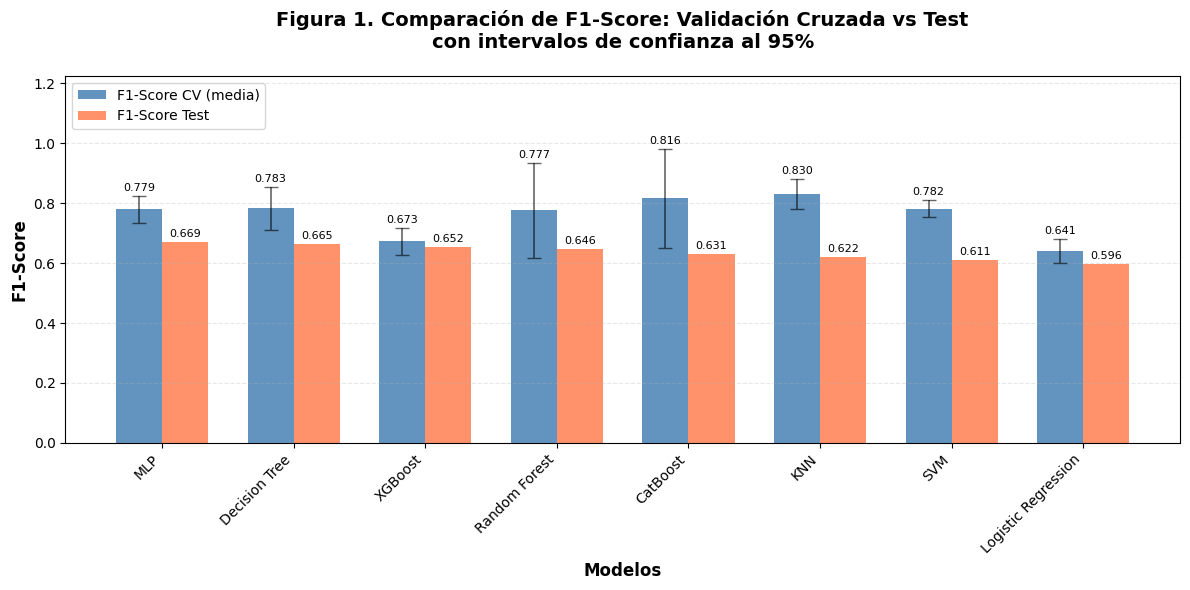

In [40]:
# Figura 1: Comparación de F1-Score (CV vs Test) con intervalos de confianza
fig, ax = plt.subplots(figsize=(12, 6))

models = df_tabla_resultados['Modelo'].values
f1_cv = df_tabla_resultados['F1 CV (μ)'].values
f1_cv_std = df_tabla_resultados['F1 CV (σ)'].values
f1_test = df_tabla_resultados['F1 Test'].values

x = np.arange(len(models))
width = 0.35

# Intervalos de confianza 95%
ci95 = 1.96 * f1_cv_std

# Barras con intervalos de confianza
bars1 = ax.bar(
    x - width/2, f1_cv, width,
    label='F1-Score CV (media)',
    color='steelblue', alpha=0.85,
    yerr=ci95, capsize=5, error_kw=dict(alpha=0.6, linewidth=1.2)
)

bars2 = ax.bar(
    x + width/2, f1_test, width,
    label='F1-Score Test',
    color='coral', alpha=0.85
)

ax.set_xlabel('Modelos', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Figura 1. Comparación de F1-Score: Validación Cruzada vs Test\ncon intervalos de confianza al 95%',
             fontsize=14, fontweight='bold', pad=20)

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='upper left')
ax.grid(axis='y', alpha=0.3, linestyle='--')

max_bar_with_ci = max(f1_cv + ci95)
max_test = max(f1_test)
ax.set_ylim(0, max(max_bar_with_ci, max_test) * 1.25)

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    h1 = bar1.get_height()
    h2 = bar2.get_height()

    ax.text(
        bar1.get_x() + bar1.get_width()/2.,
        h1 + ci95[i] + 0.01,
        f'{h1:.3f}', ha='center', va='bottom', fontsize=8
    )

    ax.text(
        bar2.get_x() + bar2.get_width()/2.,
        h2 + 0.01,
        f'{h2:.3f}', ha='center', va='bottom', fontsize=8
    )

plt.tight_layout()
plt.show()


## 4.4.4. Trade-off Precision-Recall

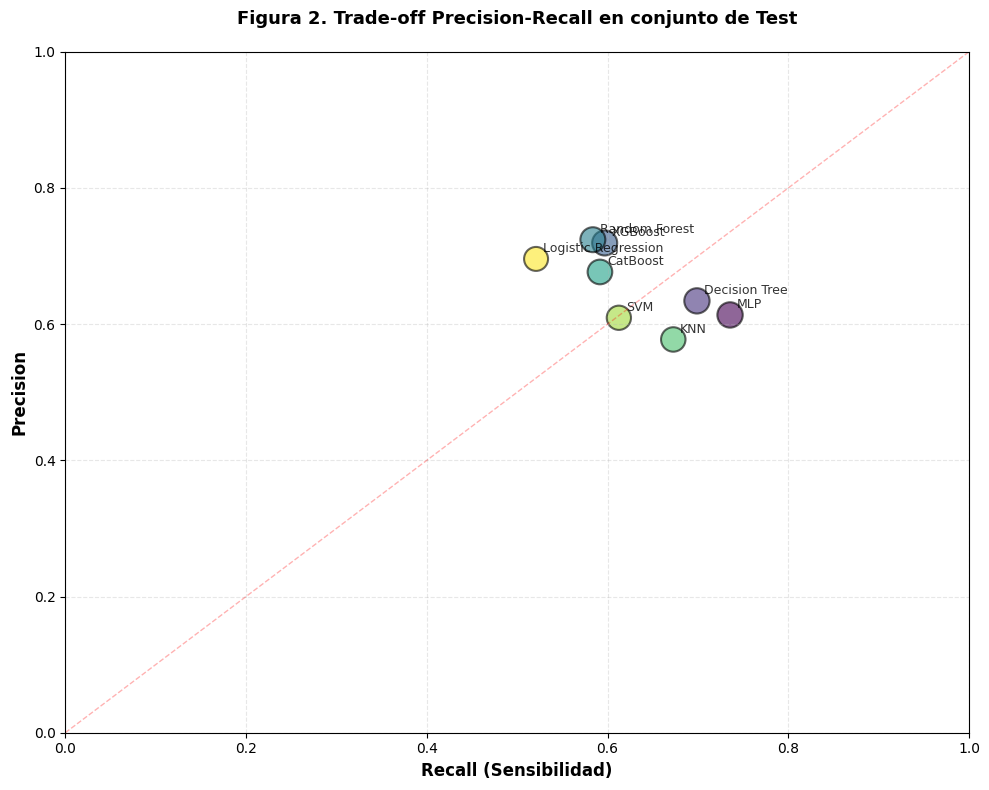

In [41]:
# Figura 2: Precision-Recall Trade-off
fig, ax = plt.subplots(figsize=(10, 8))

precision = df_tabla_resultados['Precision Test'].values
recall = df_tabla_resultados['Recall Test'].values
models = df_tabla_resultados['Modelo'].values

# Scatter plot con tamaños proporcionales al F1-Score
sizes = df_tabla_resultados['F1 Test'].values * 500

scatter = ax.scatter(recall, precision, s=sizes, alpha=0.6, 
                     c=range(len(models)), cmap='viridis', 
                     edgecolors='black', linewidth=1.5)

for i, model in enumerate(models):
    ax.annotate(model, (recall[i], precision[i]), 
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

ax.set_xlabel('Recall (Sensibilidad)', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Figura 2. Trade-off Precision-Recall en conjunto de Test', 
             fontsize=13, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Línea diagonal de referencia (F1 constante)
ax.plot([0, 1], [0, 1], 'r--', alpha=0.3, linewidth=1, label='Diagonal de referencia')

plt.tight_layout()
plt.show()

## 4.4.5. Matriz de Confusión del Mejor Modelo

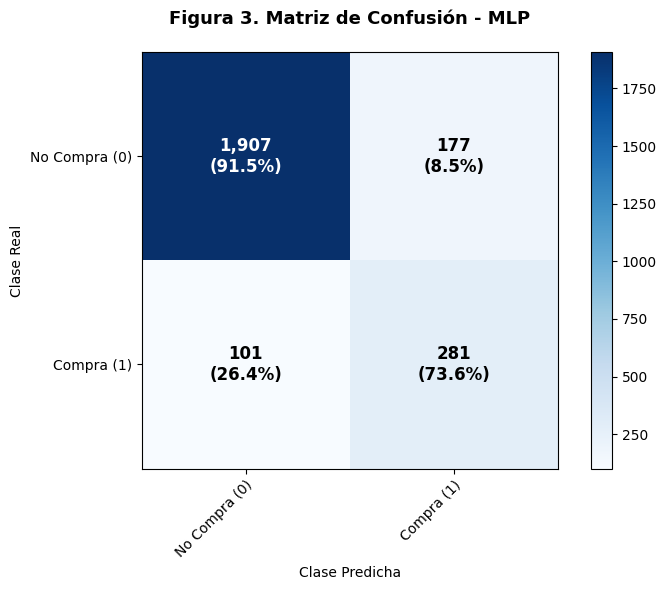

In [42]:
# Figura 4: Matriz de confusión detallada del mejor modelo
mejor_modelo = df_tabla_resultados.iloc[0]['Modelo']
best_estimator = grid_search_results[mejor_modelo]['best_estimator']

# Predecir en test
y_pred = best_estimator.predict(X_test_scaled)

# Calcular matriz de confusión
cm = confusion_matrix(y_test_flat, y_pred)

# Crear visualización
fig, ax = plt.subplots(figsize=(8, 6))

# Matriz de confusión con porcentajes
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)

classes = ['No Compra (0)', 'Compra (1)']
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes,
       yticklabels=classes,
       ylabel='Clase Real',
       xlabel='Clase Predicha')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f'{cm[i, j]:,}\n({cm_percent[i, j]:.1f}%)',
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=12, fontweight='bold')

ax.set_title(f'Figura 3. Matriz de Confusión - {mejor_modelo}', 
             fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

## 4.4.6. Comparación: Baseline vs SMOTE vs Optimizado

In [43]:
# Tabla 5: Evolución del desempeño a través de las fases
print("Tabla 5. Evolución del F1-Score por fases experimentales")
print("=" * 100)

evolucion_data = []

for model_name in df_tabla_resultados['Modelo'].values:
    # Baseline
    baseline_f1 = baseline_results[model_name]['F1-Score']
    
    # Mejor SMOTE
    mejor_smote_config = grid_search_results[model_name]['smote_config']
    if mejor_smote_config == 'Baseline':
        smote_f1 = baseline_f1
    else:
        smote_f1 = smote_results[mejor_smote_config][model_name]['F1-Score']
    
    # Optimizado
    optimizado_f1 = grid_search_results[model_name]['test_metrics']['F1-Score']
    
    # Mejoras
    mejora_smote = ((smote_f1 - baseline_f1) / baseline_f1) * 100
    mejora_opt = ((optimizado_f1 - smote_f1) / smote_f1) * 100
    mejora_total = ((optimizado_f1 - baseline_f1) / baseline_f1) * 100
    
    evolucion_data.append({
        'Modelo': model_name,
        'Baseline F1': baseline_f1,
        f'SMOTE F1 ({mejor_smote_config})': smote_f1,
        'Optimizado F1': optimizado_f1,
        'Mejora SMOTE (%)': mejora_smote,
        'Mejora Opt (%)': mejora_opt,
        'Mejora Total (%)': mejora_total
    })

df_evolucion = pd.DataFrame(evolucion_data)
df_evolucion = df_evolucion.sort_values('Optimizado F1', ascending=False)

print(df_evolucion.to_string(index=False))

print("\n" + "=" * 100)
print("Resumen de mejoras:")
print(f"  Mejora promedio por SMOTE:         {df_evolucion['Mejora SMOTE (%)'].mean():+.2f}%")
print(f"  Mejora promedio por optimización:  {df_evolucion['Mejora Opt (%)'].mean():+.2f}%")
print(f"  Mejora total promedio:             {df_evolucion['Mejora Total (%)'].mean():+.2f}%")
print(f"\n  Mayor mejora total: {df_evolucion.iloc[df_evolucion['Mejora Total (%)'].idxmax()]['Modelo']} "
      f"({df_evolucion['Mejora Total (%)'].max():+.2f}%)")
print(f"  Menor mejora total: {df_evolucion.iloc[df_evolucion['Mejora Total (%)'].idxmin()]['Modelo']} "
      f"({df_evolucion['Mejora Total (%)'].min():+.2f}%)")

Tabla 5. Evolución del F1-Score por fases experimentales
             Modelo  Baseline F1  SMOTE F1 (SMOTE 15%)  Optimizado F1  Mejora SMOTE (%)  Mejora Opt (%)  Mejora Total (%)  SMOTE F1 (Baseline)  SMOTE F1 (SMOTE 10%)
                MLP     0.633238              0.670688       0.669048          5.914011       -0.244519          5.655031                  NaN                   NaN
      Decision Tree     0.539765              0.576779       0.665006          6.857370       15.296534         23.202844                  NaN                   NaN
            XGBoost     0.660993                   NaN       0.652361          0.000000       -1.305974         -1.305974             0.660993                   NaN
      Random Forest     0.605873                   NaN       0.646377          5.652128        0.977760          6.685152                  NaN              0.640118
           CatBoost     0.649351              0.669410       0.631285          3.089163       -5.695348         -2.782

# SECCIÓN 5: REDUCCIÓN DIMENSIONAL

## 5.2. Extracción de Características Lineal (PCA)

### Paso 10: Reducción dimensional con PCA

**Objetivo:** Evaluar el impacto de PCA en el desempeño de los 2 mejores modelos obtenidos.

Se van a Mantener componentes que expliquen al menos el 95% de la varianza acumulada.

Se utilizan los 2 mejores modelos con sus configuraciones optimizadas: MLP y Decision Tree

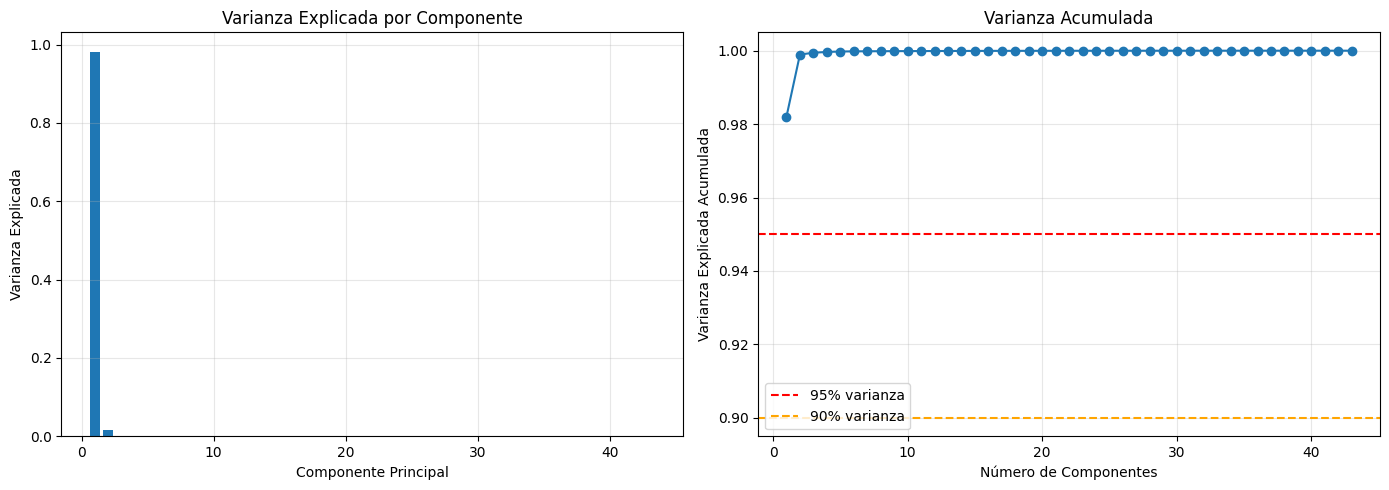


Número de componentes originales: 43
Reducción dimensional (95% varianza): 97.67%
Componentes para 90% varianza: 1
Componentes para 95% varianza: 1


In [77]:
from sklearn.decomposition import PCA

X_train_array = X_train_scaled.values if hasattr(X_train_scaled, 'values') else X_train_scaled
X_test_array = X_test_scaled.values if hasattr(X_test_scaled, 'values') else X_test_scaled

# PCA con todas las componentes para analizar varianza
pca_full = PCA(random_state=42)
pca_full.fit(X_train_array)

# Varianza explicada acumulada
cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Gráfico
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Varianza individual
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_)
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada')
axes[0].set_title('Varianza Explicada por Componente')
axes[0].grid(alpha=0.3)

# Varianza acumulada
axes[1].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, marker='o')
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% varianza')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Explicada Acumulada')
axes[1].set_title('Varianza Acumulada')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Determinar número de componentes para 95% y 90% varianza
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
n_components_90 = np.argmax(cumsum_variance >= 0.90) + 1

print(f"\nNúmero de componentes originales: {X_train_scaled.shape[1]}")
print(f"Reducción dimensional (95% varianza): {(1 - n_components_95 / X_train_scaled.shape[1]) * 100:.2f}%")
print(f"Componentes para 90% varianza: {n_components_90}")
print(f"Componentes para 95% varianza: {n_components_95}")

In [73]:
# Aplicar PCA con numero optimo de componentes
pca = PCA(n_components=n_components_95, random_state=42)
X_train_pca = pca.fit_transform(X_train_array)
X_test_pca = pca.transform(X_test_array)

print(f"Dimensiones originales: {X_train_array.shape}")
print(f"Dimensiones PCA: {X_train_pca.shape}")
print(f"Varianza explicada total: {pca.explained_variance_ratio_.sum():.4f}")

Dimensiones originales: (9864, 43)
Dimensiones PCA: (9864, 1)
Varianza explicada total: 0.9820


In [74]:
# Analisis de componentes principales - Top features por componente
components_df = pd.DataFrame(
    pca.components_,
    columns=X_train_scaled.columns,
    index=[f'PC{i+1}' for i in range(n_components_95)]
)

print("Top 5 features con mayor peso absoluto en cada una de las primeras 5 componentes:")
for i in range(min(5, n_components_95)):
    pc = f'PC{i+1}'
    top_features = components_df.loc[pc].abs().sort_values(ascending=False).head(5)
    print(f"\n{pc} (Varianza explicada: {pca.explained_variance_ratio_[i]:.4f}):")
    for feat, weight in top_features.items():
        original_weight = components_df.loc[pc, feat]
        print(f"  {feat}: {original_weight:.4f}")

Top 5 features con mayor peso absoluto en cada una de las primeras 5 componentes:

PC1 (Varianza explicada: 0.9820):
  Informational_Duration: 1.0000
  Informational: 0.0057
  PageValues: 0.0041
  ProductRelated_Duration: 0.0037
  Administrative_Duration: 0.0034


### Evaluación de Modelos con PCA

Evaluamos los 2 mejores modelos (MLP y Decision Tree) con las componentes PCA, usando sus hiperparámetros optimizados.

In [78]:
# Resultados de los 2 mejores modelos
baseline_pca = {
    'MLP': {
        'Accuracy': accuracy_score(y_test_flat, grid_search_results['MLP']['best_estimator'].predict(X_test_scaled)),
        'F1-Score': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'MLP']['F1 Test'].values[0],
        'Precision': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'MLP']['Precision Test'].values[0],
        'Recall': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'MLP']['Recall Test'].values[0],
        'ROC-AUC': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'MLP']['ROC-AUC Test'].values[0]
    },
    'Decision Tree': {
        'F1-Score': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'Decision Tree']['F1 Test'].values[0],
        'Precision': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'Decision Tree']['Precision Test'].values[0],
        'Recall': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'Decision Tree']['Recall Test'].values[0],
        'ROC-AUC': df_tabla_resultados[df_tabla_resultados['Modelo'] == 'Decision Tree']['ROC-AUC Test'].values[0]
    }
}

print("Resultados (con hiperparámetros optimizados):")
for model_name, metrics in baseline_pca.items():
    print(f"\n{model_name}:")
    for metric, value in metrics.items():
        if not np.isnan(value):

            print(f"  {metric}: {value:.4f}")

Resultados (con hiperparámetros optimizados):

MLP:
  Accuracy: 0.8873
  F1-Score: 0.6690
  Precision: 0.6135
  Recall: 0.7356
  ROC-AUC: 0.9144

Decision Tree:
  F1-Score: 0.6650
  Precision: 0.6342
  Recall: 0.6990


In [79]:
# Entrenar modelos con PCA usando hiperparámetros optimizados
models_pca = {
    'MLP': MLPClassifier(
        **grid_search_results['MLP']['best_params'],
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        **grid_search_results['Decision Tree']['best_params'],
        random_state=42
    )
}

pca_results = {}

print(f"Número de componentes PCA: {n_components_95}")
print(f"Varianza explicada acumulada: {cumsum_variance[n_components_95-1]*100:.2f}%")
print(f"Dimensiones: {X_train_pca.shape[1]} componentes (reducido desde {X_train_scaled.shape[1]} features)")

for name, model in models_pca.items():
    print(f"\n{name}:")
    
    start_time = time.time()
    model.fit(X_train_pca, y_train_flat)
    y_pred = model.predict(X_test_pca)
    
    # Verificar que el modelo predice ambas clases
    unique_preds = np.unique(y_pred)
    print(f"Clases predichas: {unique_preds}")
    
    training_time = time.time() - start_time
    
    pca_results[name] = {
        'Accuracy': accuracy_score(y_test_flat, y_pred),
        'Precision': precision_score(y_test_flat, y_pred, zero_division=0),
        'Recall': recall_score(y_test_flat, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test_flat, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test_flat, model.predict_proba(X_test_pca)[:, 1]) if hasattr(model, 'predict_proba') else np.nan,
        'Training Time (s)': training_time
    }
    
    print(f"  Completado en {training_time:.2f}s")
    print(f"  F1-Score: {pca_results[name]['F1-Score']:.4f}")
    print(f"  Recall: {pca_results[name]['Recall']:.4f}")
    print(f"  Precision: {pca_results[name]['Precision']:.4f}")

Número de componentes PCA: 1
Varianza explicada acumulada: 98.20%
Dimensiones: 1 componentes (reducido desde 43 features)

MLP:
Clases predichas: [False]
  Completado en 16.78s
  F1-Score: 0.0000
  Recall: 0.0000
  Precision: 0.0000

Decision Tree:
Clases predichas: [False  True]
  Completado en 0.01s
  F1-Score: 0.4036
  Recall: 0.2932
  Precision: 0.6474
Clases predichas: [False]
  Completado en 16.78s
  F1-Score: 0.0000
  Recall: 0.0000
  Precision: 0.0000

Decision Tree:
Clases predichas: [False  True]
  Completado en 0.01s
  F1-Score: 0.4036
  Recall: 0.2932
  Precision: 0.6474


In [85]:
# Comparacion de resultados PCA vs optimizado (antes de PCA)
comparison_pca = pd.DataFrame({
    'MLP (optimizado)': baseline_pca['MLP'],
    'MLP (PCA)': pca_results['MLP'],
    'Decision Tree (optimizado)': baseline_pca['Decision Tree'],
    'Decision Tree (PCA)': pca_results['Decision Tree']
}).T

comparison_pca = comparison_pca[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

print(comparison_pca.round(4).to_string())

# Calcular diferencias
for model_name in ['MLP', 'Decision Tree']:
    baseline_key = f'{model_name} (optimizado)'
    pca_key = f'{model_name} (PCA)'
    
    f1_diff = comparison_pca.loc[pca_key, 'F1-Score'] - comparison_pca.loc[baseline_key, 'F1-Score']
    f1_pct = (f1_diff / comparison_pca.loc[baseline_key, 'F1-Score']) * 100
    
    print(f"\n{model_name}:")
    print(f"F1-Score optimizado: {comparison_pca.loc[baseline_key, 'F1-Score']:.4f}")
    print(f"F1-Score PCA:      {comparison_pca.loc[pca_key, 'F1-Score']:.4f}")
    print(f"Diferencia:        {f1_diff:+.4f} ({f1_pct:+.2f}%)")
    
    if abs(f1_pct) < 5:
        print(f"Evaluacion: Degradacion minima (<5%)")
    elif abs(f1_pct) < 10:
        print(f"Evaluacion: Degradacion moderada (5-10%)")
    else:
        print(f"Evaluacion: Degradacion significativa (>10%)")

                            Accuracy  Precision  Recall  F1-Score  ROC-AUC
MLP (optimizado)              0.8873     0.6135  0.7356    0.6690   0.9144
MLP (PCA)                     0.8451     0.0000  0.0000    0.0000   0.7652
Decision Tree (optimizado)       NaN     0.6342  0.6990    0.6650      NaN
Decision Tree (PCA)           0.8658     0.6474  0.2932    0.4036   0.8376

MLP:
F1-Score optimizado: 0.6690
F1-Score PCA:      0.0000
Diferencia:        -0.6690 (-100.00%)
Evaluacion: Degradacion significativa (>10%)

Decision Tree:
F1-Score optimizado: 0.6650
F1-Score PCA:      0.4036
Diferencia:        -0.2614 (-39.31%)
Evaluacion: Degradacion significativa (>10%)
